# FAST-based feature filtering demo

This notebook demonstrates internal FAST-based feature filtering for factual explanations.

The core idea:
- Run an internal FAST pass on the same batch to obtain per-instance feature weights.
- Aggregate those weights and keep only the top-k most important features for the batch.
- Run the full factual explanation on this reduced feature set, reducing compute cost.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import WrapCalibratedExplainer
from calibrated_explanations.api.config import ExplainerBuilder


In [38]:
# Generate a simple classification dataset with many features
X, y = make_classification(
    n_samples=2000,
    n_features=2000,
    n_informative=5,
    n_redundant=5,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=200, random_state=42)

learner = RandomForestClassifier(n_estimators=50, random_state=42)
learner.fit(X_train_proper, y_train_proper)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Build an ExplainerConfig with internal feature filtering enabled
builder = ExplainerBuilder(learner)
config = (
    builder
    .task("classification")
    .perf_parallel(False)  # Disabled parallelism
    .perf_feature_filter(True, per_instance_top_k=5)
    .build_config()
)

# Construct the wrapper from the config
wrapper = WrapCalibratedExplainer._from_config(config)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper.calibrate(X_cal, y_cal)
explainer = wrapper.explainer
explainer

CalibratedExplainer(mode=classification, learner=RandomForestClassifier(n_estimators=50, random_state=42))

In [ ]:
# Run factual explanations with internal FAST-based feature filtering enabled
explanations = wrapper.explain_factual(X_test)

In [20]:
explanations[:5].to_narrative()

,instance_index,factual_explanation_beginner,factual_explanation_advanced,expertise_level,problem_type
0,0,⚠️ Use caution: uncertainty is high.\n\nPredic...,⚠️ Use caution: calibrated probability interva...,"(beginner, advanced)",binary_classification
1,1,Prediction: 1\nCalibrated Probability: 0.831 [...,Prediction: 1\nCalibrated Probability: 0.831\n...,"(beginner, advanced)",binary_classification
2,2,Prediction: 1\nCalibrated Probability: 0.831 [...,Prediction: 1\nCalibrated Probability: 0.831\n...,"(beginner, advanced)",binary_classification
3,3,Prediction: 1\nCalibrated Probability: 0.269 [...,Prediction: 1\nCalibrated Probability: 0.269\n...,"(beginner, advanced)",binary_classification
4,4,Prediction: 1\nCalibrated Probability: 0.263 [...,Prediction: 1\nCalibrated Probability: 0.263\n...,"(beginner, advanced)",binary_classification


Prediction [ Low ,  High]
0.723 [0.667, 0.870]
Value : Feature                                  Weight [ Low  ,  High ]
1.85  : 179 > -2.03                              -0.036 [-0.147,  0.004]
-0.11 : 87 <= 1.12                               -0.036 [-0.147,  0.004]



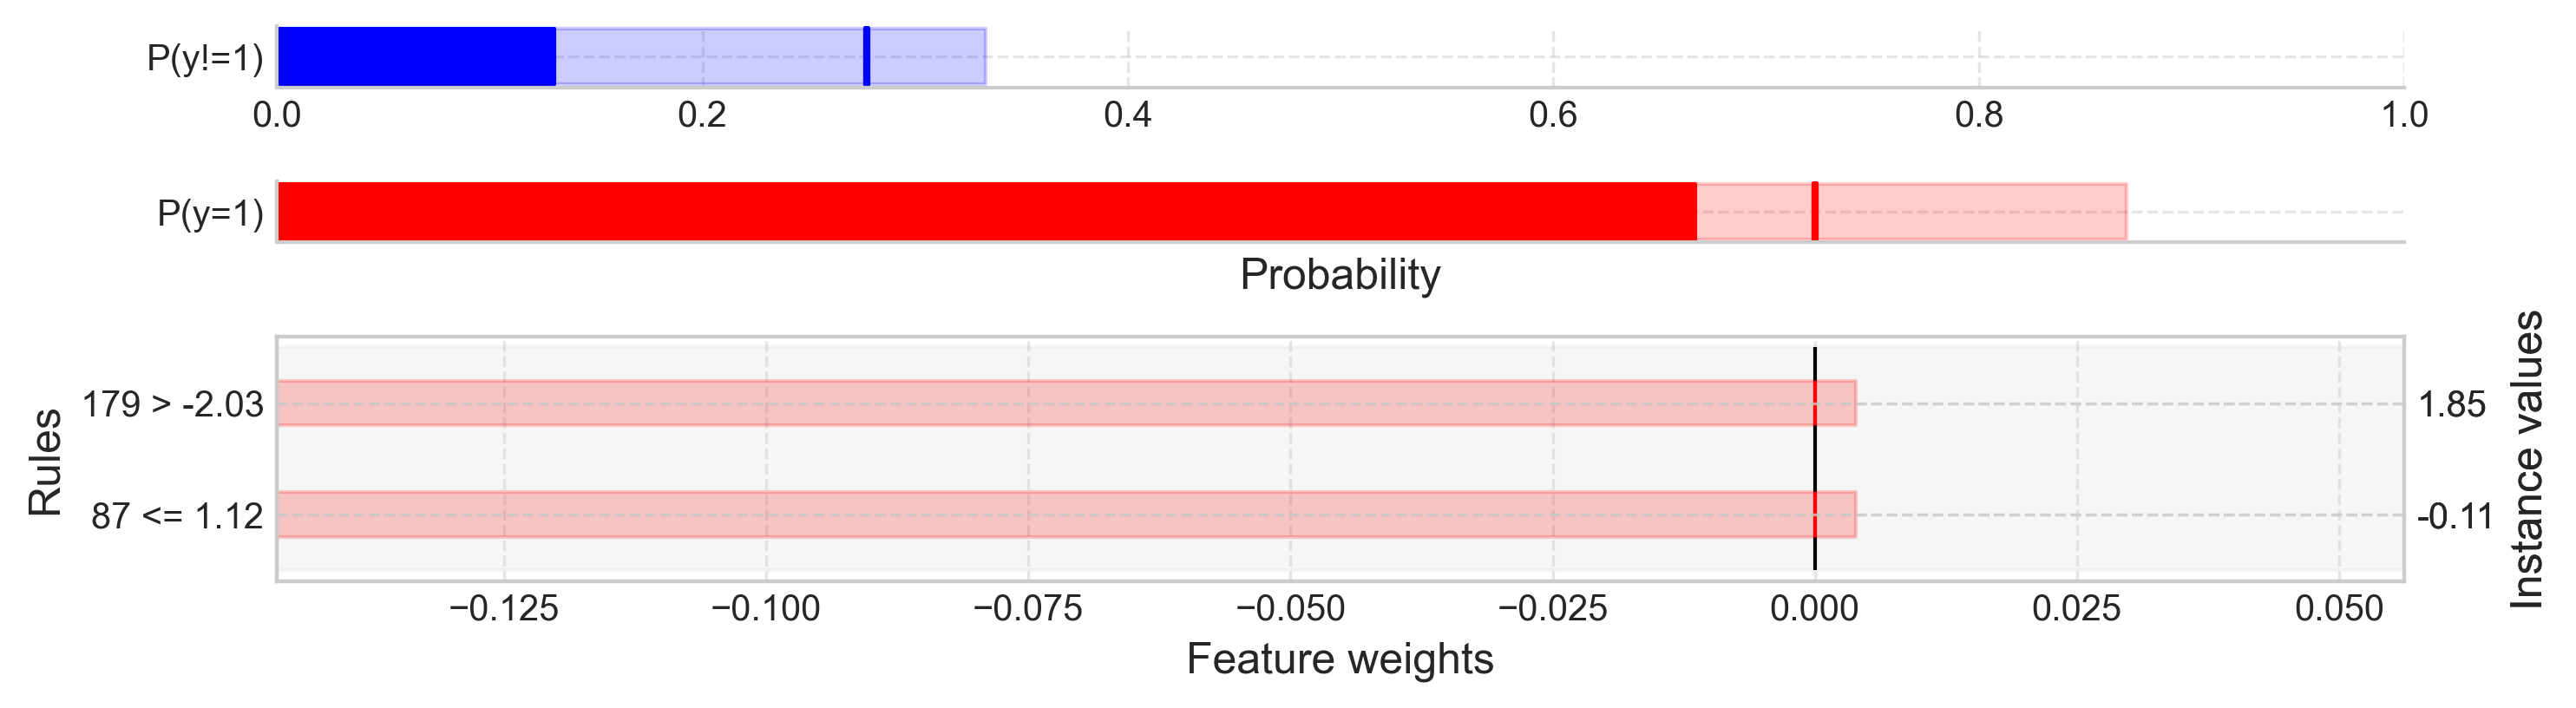

Prediction [ Low ,  High]
0.831 [0.824, 0.870]
Value : Feature                                  Weight [ Low  ,  High ]
-0.53 : 162 <= -0.33                              0.252 [ 0.206,  0.286]
-0.87 : 133 <= 3.17                               0.252 [ 0.206,  0.286]
-0.81 : 18 > -2.17                                0.252 [ 0.206,  0.286]
-1.4  : 4 <= 0.99                                 0.252 [ 0.206,  0.286]
0.07  : 87 <= 1.12                                0.036 [-0.038,  0.060]
0.01  : 179 > -2.03                              -0.000 [-0.038,  0.008]
-2.07 : 140 <= 0.01                              -0.000 [-0.038,  0.008]
-0.96 : 100 > -1.46                              -0.000 [-0.038,  0.008]
0.08  : 88 <= 1.19                               -0.000 [-0.038,  0.008]



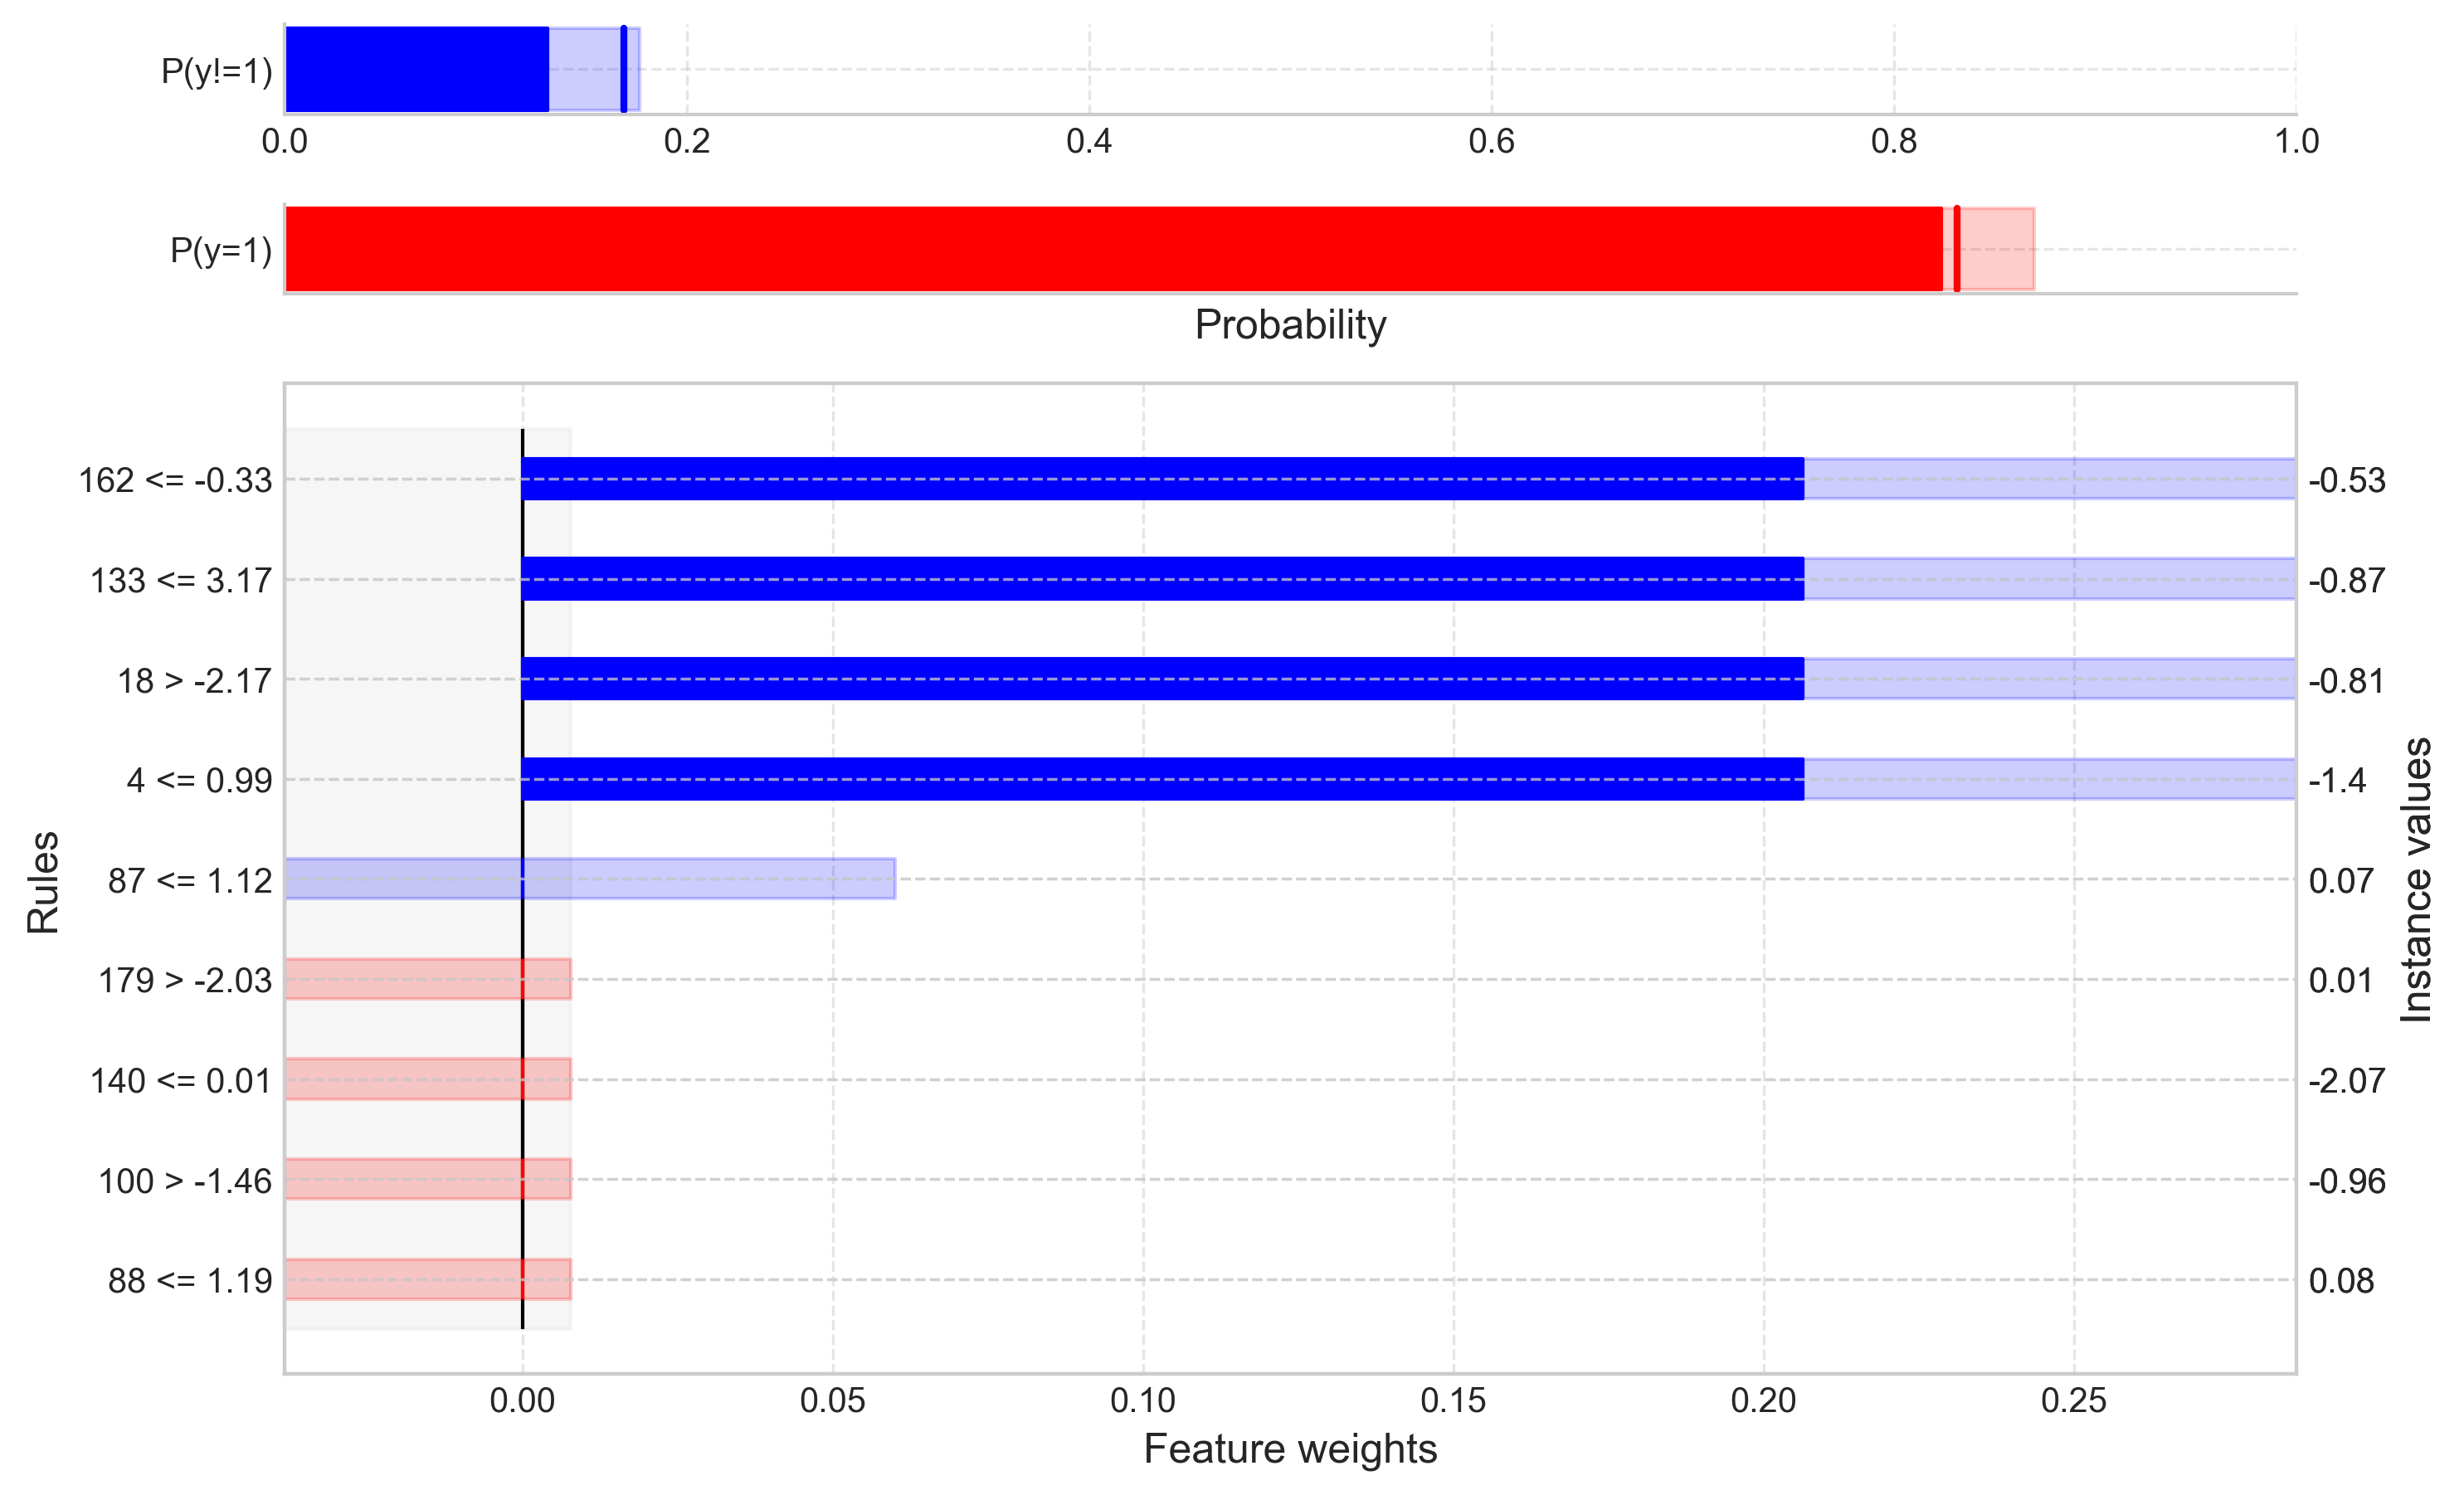

Prediction [ Low ,  High]
0.831 [0.824, 0.870]
Value : Feature                                  Weight [ Low  ,  High ]
-1.01 : 133 <= 3.17                               0.263 [ 0.216,  0.298]
1.43  : 162 > -0.33                               0.072 [-0.038,  0.112]
-0.13 : 140 <= 0.01                              -0.002 [-0.038,  0.005]
-0.93 : 88 <= 1.19                               -0.001 [-0.038,  0.007]
-0.87 : 179 > -2.03                              -0.000 [-0.038,  0.008]
1.55  : 107 > 0.54                               -0.000 [-0.038,  0.008]
-0.05 : 100 > -1.46                              -0.000 [-0.038,  0.008]
-2.98 : 87 <= 1.12                               -0.000 [-0.038,  0.008]
-0.32 : 18 > -2.17                               -0.000 [-0.038,  0.008]



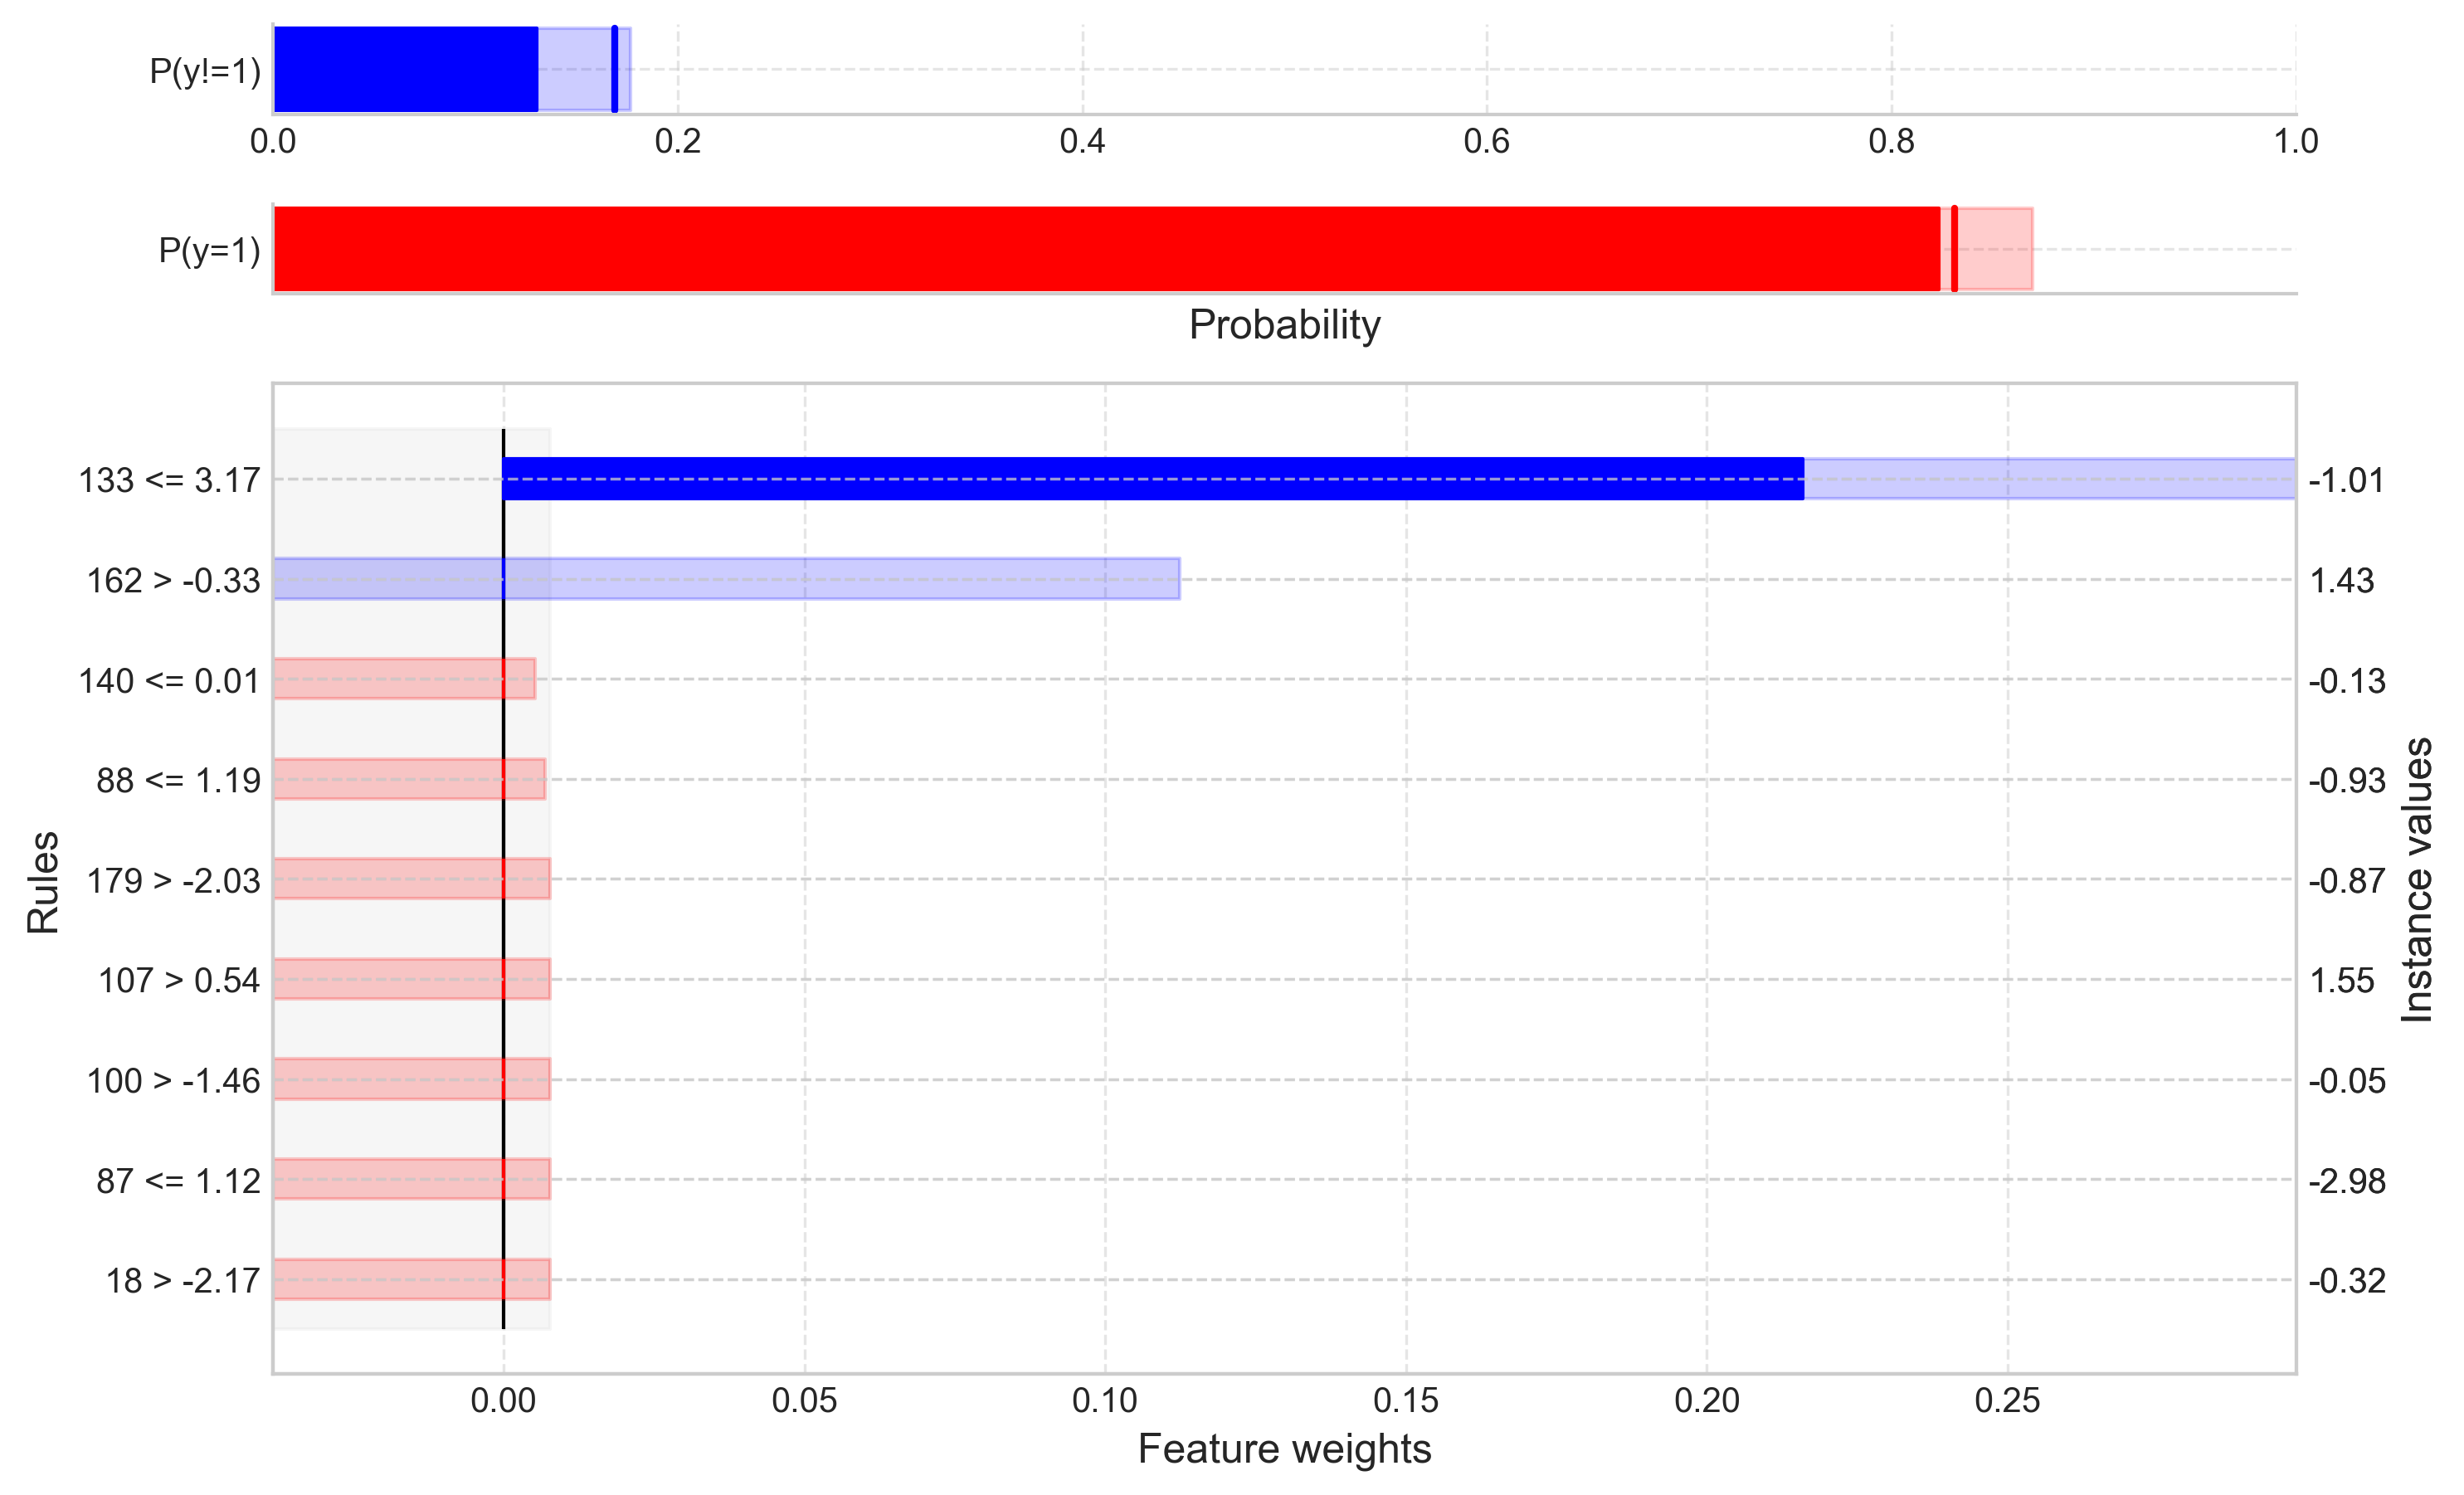

Prediction [ Low ,  High]
0.269 [0.222, 0.286]
Value : Feature                                  Weight [ Low  ,  High ]
1.29  : 162 > -0.33                              -0.527 [-0.601, -0.503]
-1.28 : 71 <= 0.41                               -0.273 [-0.322, -0.231]
-1.13 : 5 <= 0.45                                -0.273 [-0.322, -0.231]
0.77  : 178 > -1.21                               0.269 [ 0.269,  0.269]
-0.8  : 4 <= 0.99                                 0.005 [-0.009,  0.046]



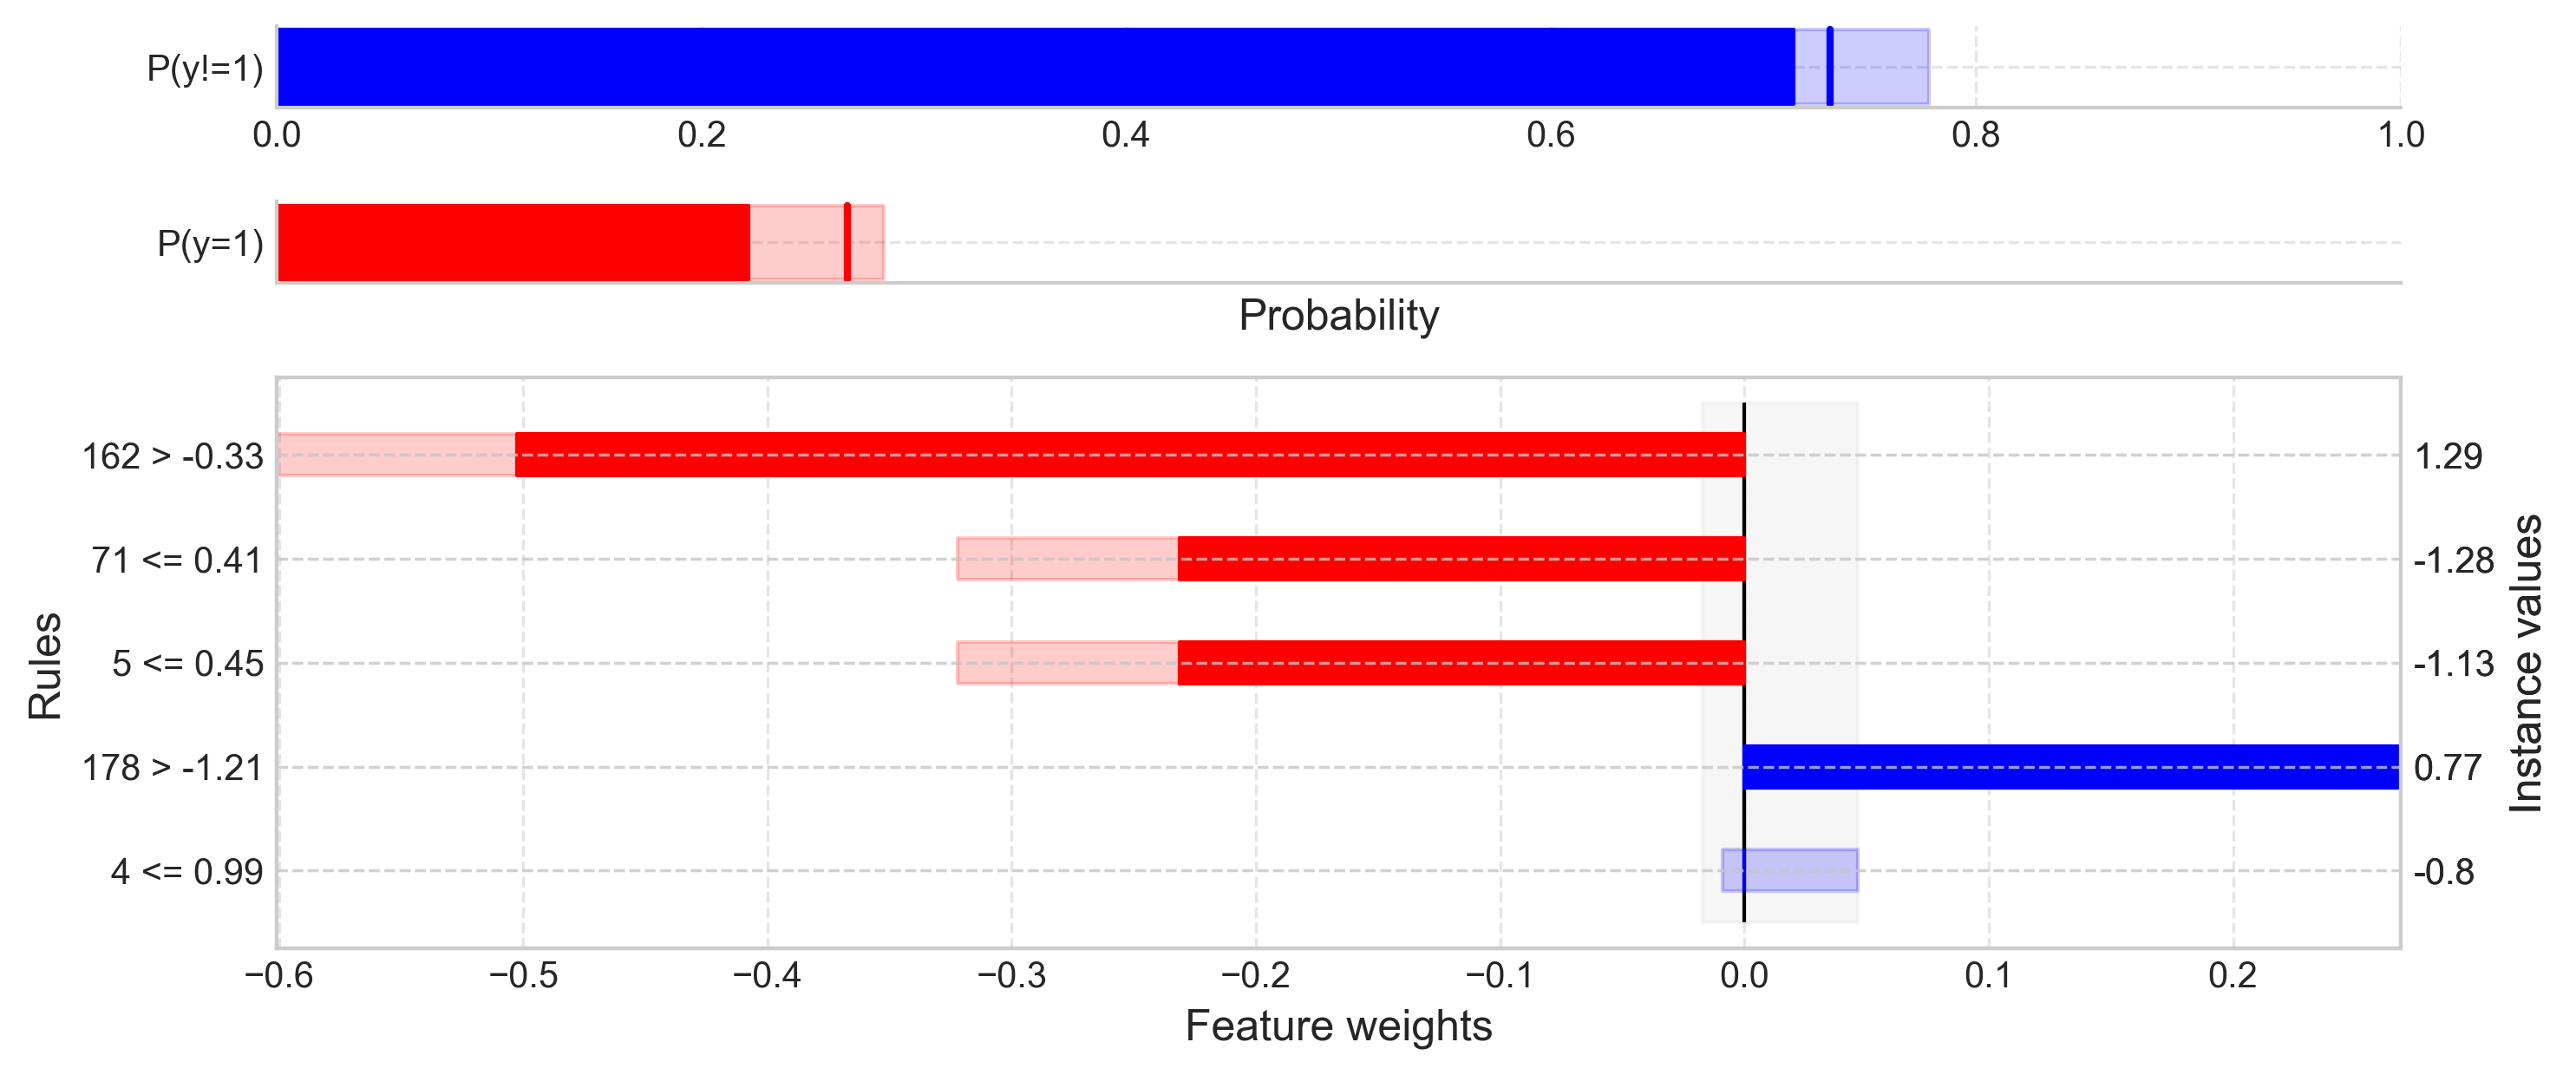

Prediction [ Low ,  High]
0.263 [0.222, 0.278]
Value : Feature                                  Weight [ Low  ,  High ]
0.64  : 162 > -0.33                              -0.279 [-0.328, -0.237]
-0.79 : 71 <= 0.41                               -0.279 [-0.328, -0.237]
-0.1  : 5 <= 0.45                                -0.279 [-0.328, -0.237]
0.38  : 178 > -1.21                               0.263 [ 0.263,  0.263]
-1.11 : 179 > -2.03                              -0.005 [-0.023,  0.041]



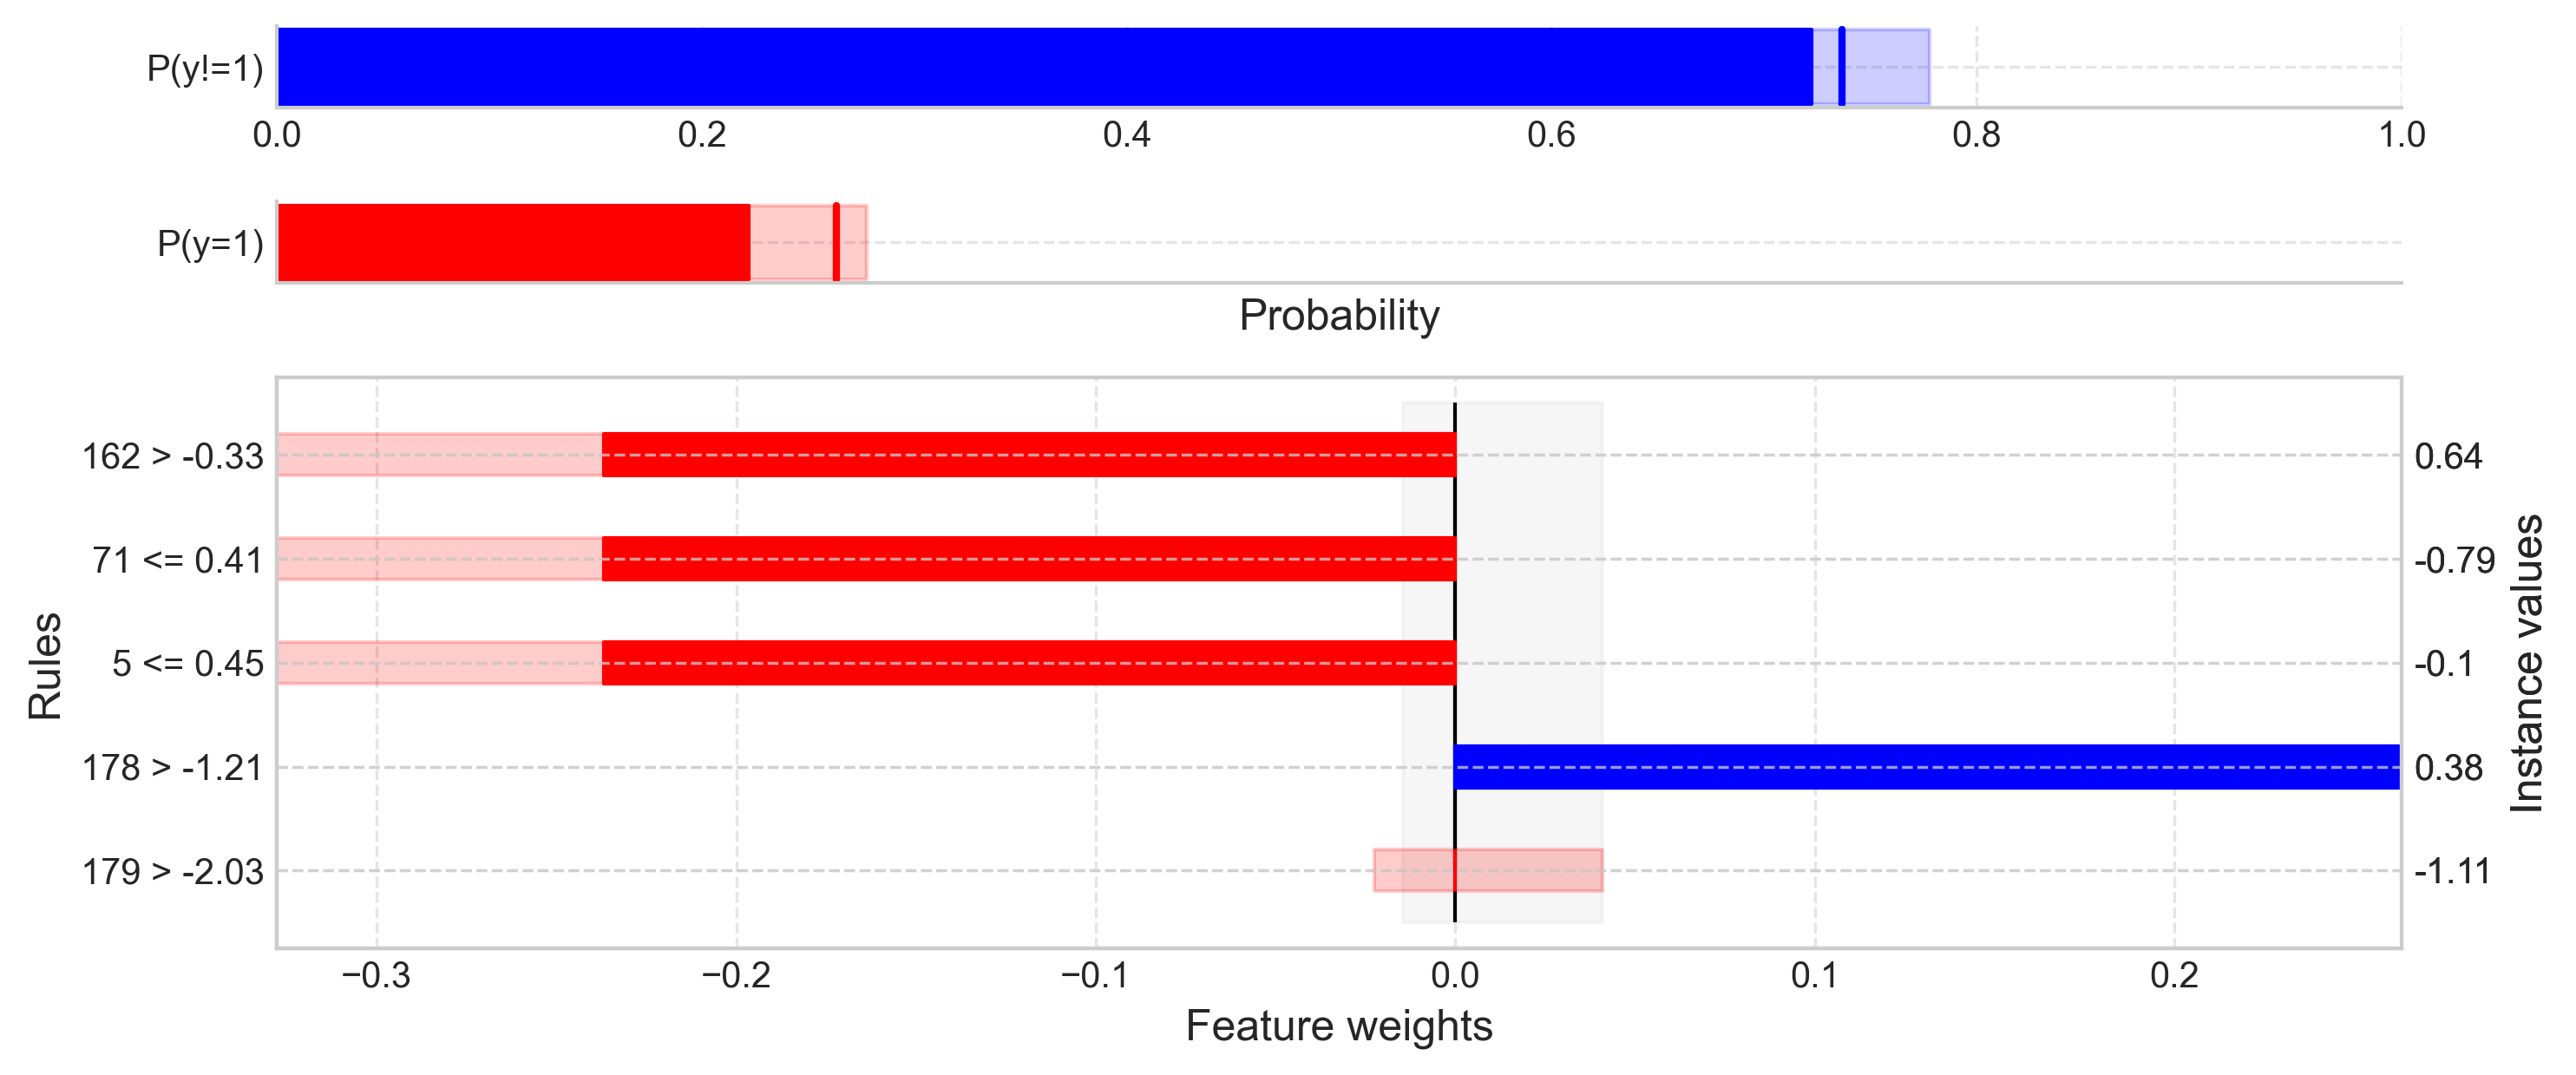

In [34]:
for e in explanations[:5]:
    print(e)
    e.plot(uncertainty=True)

In [35]:
# Inspect how many features remain after filtering
num_features = explainer.num_features
ignored = set(explanations.features_to_ignore)
kept = [f for f in range(num_features) if f not in ignored]
num_features, len(kept), kept

(200, 13, [4, 5, 18, 71, 87, 88, 100, 107, 133, 140, 162, 178, 179])

The length of `kept` should be less than or equal to `per_instance_top_k` passed to `perf_feature_filter`.

You can tweak `per_instance_top_k` and rerun the notebook to see how the effective feature budget changes.

In [36]:
# Construct the wrapper from the config
wrapper_all = WrapCalibratedExplainer(learner)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper_all.calibrate(X_cal, y_cal)
explainer = wrapper_all.explainer


In [37]:
explanations_all = wrapper_all.explain_factual(X_test)
explanations_all.features_to_ignore

array([], dtype=int32)